In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import os
if not os.path.isdir('figures'):
    os.makedirs('figures')
    
if not os.path.isdir('brute_force'):
    os.makedirs('brute_force')

In [2]:
epochs = 1500 #From previous part 1B
batch_size = 8
num_neurons = 10
seed = 10

beta = 1e-3
alpha = 1e-3

l2=keras.regularizers.l2(beta)
sgd=keras.optimizers.SGD(learning_rate=alpha)

histories={}

np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#read and divide data into test and train sets 
admit_data = np.genfromtxt('admission_predict.csv', delimiter= ',')
X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
Y_data = Y_data.reshape(Y_data.shape[0], 1)

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data,test_size = 0.3, random_state = seed, shuffle=True)

#Preprocess by standardizing the Xtrain and Xtest based on Xtrain stats
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
def get_baseline_model(input_size):
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, input_dim = input_size, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=sgd,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])
    
    return model

In [5]:
train_data_6_feature = []
test_data_6_feature = []

#Make train and test set for 6 features RFE.
for feature_idx in range(7):
    temp = np.delete(X_train,obj=feature_idx,axis=1)
    train_data_6_feature.append(temp)
    temp = np.delete(X_test,obj=feature_idx,axis=1)
    test_data_6_feature.append(temp)

In [6]:
#Brute force 6 features
mse_6_features_all = []
for i in range (5):
    print("Experiments %s"%i)
    #Repeat experiments 5 times
    mse_6_features = []
    for feature_idx in range(7):
        #Extract the train and test data from the list above to prepare for training
        train_data = train_data_6_feature[feature_idx]
        test_data = test_data_6_feature[feature_idx]
        #build a model with input size =6
        model = get_baseline_model(input_size=6)
        #train the model with early stopper, monitoring the validate mean squared error.
        #print out the minimum validation m.s.e for each models.
        early_stopper = keras.callbacks.EarlyStopping(monitor='val_mse',patience=10,mode='min',min_delta=1e-5)
        csv_logger = keras.callbacks.CSVLogger('./brute_force/6_features_remove_feature_%s_exp_%s.csv'%(feature_idx,i))
        callback_list = [csv_logger,early_stopper]
        #results is the history of this particular set of training data, test data
        results = model.fit(train_data,Y_train,validation_data=(test_data,Y_test),
                           epochs = epochs, batch_size=batch_size, verbose=0, callbacks=callback_list)
        #obtain the best mse for this model and print it out below
        best_mse = min(results.history['val_mse'])
        print("min M.S.E for 6 features (removed feature %s): %.5f"%(feature_idx,best_mse))
        mse_6_features.append(best_mse)
    mse_6_features_all.append(mse_6_features)

Experiments 0
min M.S.E for 6 features (removed feature 0): 0.00639
min M.S.E for 6 features (removed feature 1): 0.00674
min M.S.E for 6 features (removed feature 2): 0.00619
min M.S.E for 6 features (removed feature 3): 0.00601
min M.S.E for 6 features (removed feature 4): 0.00707
min M.S.E for 6 features (removed feature 5): 0.00610
min M.S.E for 6 features (removed feature 6): 0.00677
Experiments 1
min M.S.E for 6 features (removed feature 0): 0.00816
min M.S.E for 6 features (removed feature 1): 0.00708
min M.S.E for 6 features (removed feature 2): 0.00711
min M.S.E for 6 features (removed feature 3): 0.00606
min M.S.E for 6 features (removed feature 4): 0.00618
min M.S.E for 6 features (removed feature 5): 0.01020
min M.S.E for 6 features (removed feature 6): 0.00615
Experiments 2
min M.S.E for 6 features (removed feature 0): 0.00607
min M.S.E for 6 features (removed feature 1): 0.00747
min M.S.E for 6 features (removed feature 2): 0.00669
min M.S.E for 6 features (removed featur

In [10]:
print(mse_6_features_all)
mse_6_features_ave = np.array(mse_6_features_all).mean(axis=0)
print(mse_6_features_ave)        

[[0.006390531547367573, 0.006739077158272266, 0.00619416031986475, 0.006010904908180237, 0.007069908548146486, 0.006102405488491058, 0.00676949555054307], [0.008164039812982082, 0.007080550771206617, 0.007110775448381901, 0.006063258741050959, 0.006181005854159594, 0.010203058831393719, 0.00615155091509223], [0.006066316273063421, 0.007471124175935984, 0.00669307354837656, 0.007276561576873064, 0.007250072434544563, 0.007252763025462627, 0.0072798472829163074], [0.006951445247977972, 0.006220423616468906, 0.00657781632617116, 0.006680761463940144, 0.008204406127333641, 0.00807446613907814, 0.006595808081328869], [0.007438143249601126, 0.009505276568233967, 0.006605156697332859, 0.007758229970932007, 0.008372846990823746, 0.006529851350933313, 0.005263785365968943]]
[0.0070021  0.00740329 0.0066362  0.00675794 0.00741565 0.00763251
 0.0064121 ]


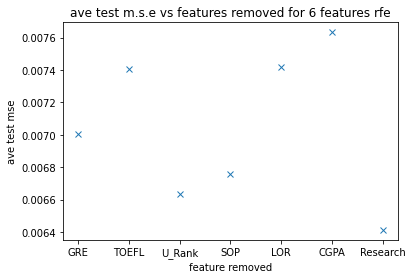

In [12]:
#Plot the ave min m.s.e of 6 features vs the feature removed.
plt.plot(['GRE','TOEFL','U_Rank','SOP','LOR','CGPA','Research'],mse_6_features_ave,linestyle='None',marker = 'x')
plt.ylabel('ave test mse')
plt.xlabel('feature removed')
plt.title("ave test m.s.e vs features removed for 6 features rfe")
plt.savefig('./figures/2B_brute_force_6_features_mse.png')
plt.show()

In [15]:
#keep model with lowest m.s.e (model that removed feature 6 has lowest average test mse)
X6_train, X6_test = train_data_6_feature[6],test_data_6_feature[6]
print(X6_train)

[[ 1.42832554  1.60033916  0.81007205  1.61476636  0.63111055  1.75693791]
 [ 2.03141     2.09401705  1.68922001  1.12224503  1.17990233  1.65722655]
 [-1.07016722 -0.86805029 -0.94822387 -0.35531896  0.63111055  0.21141182]
 ...
 [-0.20861799 -0.3743724  -0.06907591  0.13720237 -1.0152648  -0.50318626]
 [-1.41478691 -1.19716888 -0.06907591 -1.34036162 -0.46647302  0.0950819 ]
 [-0.29477291 -0.86805029 -0.06907591 -0.84784029 -1.0152648   0.12831902]]


In [24]:
print(X6_test)

[[-0.72554753 -0.2098131  -0.06907591  0.13720237 -1.0152648  -0.6527533 ]
 [ 0.39446647  0.28386479  0.81007205  0.6297237   0.63111055  0.12831902]
 [-1.15632214 -1.19716888 -0.94822387 -0.35531896  0.08231877 -0.9020317 ]
 [-1.84556153 -1.36172818 -0.94822387 -0.84784029 -0.46647302 -1.58339266]
 [-0.03630815 -0.86805029 -0.06907591 -1.34036162 -0.46647302 -1.99885666]
 [-0.46708276 -1.36172818 -1.82737184 -0.84784029 -0.46647302 -0.28714498]
 [ 2.03141     2.09401705  0.81007205  1.61476636  1.72869412  1.49104095]
 [ 1.2560157   1.60033916  0.81007205  1.12224503  1.72869412  1.35809247]
 [ 1.2560157   1.27122056  1.68922001  0.6297237   0.08231877  1.39132959]
 [-0.9840123   0.11930549  1.68922001 -0.35531896 -0.46647302 -0.20405218]
 [ 0.91139601 -0.5389317   1.68922001 -0.35531896  0.08231877  0.39421598]
 [ 0.48062139  0.44842408  0.81007205  0.6297237   1.72869412  0.87615422]
 [ 0.39446647  0.28386479 -0.06907591 -0.35531896 -0.46647302 -0.10434082]
 [-0.12246307 -1.19716888

In [16]:
train_data_5_feature = []
test_data_5_feature = []

#Make train and test set for 5 features RFE.
for feature_idx in range(6):
    temp = np.delete(X6_train,obj=feature_idx,axis=1)
    train_data_5_feature.append(temp)
    temp = np.delete(X6_test,obj=feature_idx,axis=1)
    test_data_5_feature.append(temp)

In [19]:
#Brute force 5 features
mse_5_features_all = []
for i in range(5):
    print("Experiments %s"%i)
    #Repeat 5 times
    mse_5_features = []
    for feature_idx in range(6):
        #Extract the train and test data from the list above to prepare for training
        train_data = train_data_5_feature[feature_idx]
        test_data = test_data_5_feature[feature_idx]
        #build a model with input size =5
        model = get_baseline_model(input_size=5)
        #train the model with early stopper, monitoring the validate mean squared error.
        #print out the minimum validation m.s.e for each models.
        early_stopper = keras.callbacks.EarlyStopping(monitor='val_mse',patience=10,mode='min',min_delta=1e-5)
        csv_logger = keras.callbacks.CSVLogger('./brute_force/5_features_remove_feature_%s_exp_%s.csv'%(feature_idx,i))
        callback_list = [csv_logger,early_stopper]
        #results is the history of this particular set of training data, test data
        results = model.fit(train_data,Y_train,validation_data=(test_data,Y_test),
                           epochs = epochs, batch_size=batch_size, verbose=0, callbacks=callback_list)
        #obtain the best mse for this model and print it out below
        best_mse = min(results.history['val_mse'])
        print("min M.S.E for 5 features (removed feature %s): %.6f"%(feature_idx,best_mse))
        mse_5_features.append(best_mse)
    mse_5_features_all.append(mse_5_features)

Experiments 0
min M.S.E for 5 features (removed feature 0): 0.007440
min M.S.E for 5 features (removed feature 1): 0.005839
min M.S.E for 5 features (removed feature 2): 0.008047
min M.S.E for 5 features (removed feature 3): 0.006674
min M.S.E for 5 features (removed feature 4): 0.006961
min M.S.E for 5 features (removed feature 5): 0.008678
Experiments 1
min M.S.E for 5 features (removed feature 0): 0.006024
min M.S.E for 5 features (removed feature 1): 0.007673
min M.S.E for 5 features (removed feature 2): 0.007106
min M.S.E for 5 features (removed feature 3): 0.005745
min M.S.E for 5 features (removed feature 4): 0.006495
min M.S.E for 5 features (removed feature 5): 0.009884
Experiments 2
min M.S.E for 5 features (removed feature 0): 0.006168
min M.S.E for 5 features (removed feature 1): 0.007344
min M.S.E for 5 features (removed feature 2): 0.006639
min M.S.E for 5 features (removed feature 3): 0.005957
min M.S.E for 5 features (removed feature 4): 0.007262
min M.S.E for 5 feature

In [21]:
print(mse_5_features_all)
mse_5_features_ave = np.array(mse_5_features_all).mean(axis=0)
print(mse_5_features_ave)

[[0.0074404641054570675, 0.0058387890458106995, 0.008047472685575485, 0.006673605181276798, 0.0069608367048203945, 0.008677821606397629], [0.006024339701980352, 0.007673123385757208, 0.007106287404894829, 0.0057451725006103516, 0.006494696252048016, 0.009883983992040157], [0.006168258376419544, 0.007343880832195282, 0.006638878025114536, 0.005957187153398991, 0.007261552847921848, 0.007533891126513481], [0.006927694659680128, 0.00726270629093051, 0.005911201238632202, 0.006895606871694326, 0.007539248093962669, 0.007857751101255417], [0.006797597743570805, 0.00599078880622983, 0.006210411433130503, 0.006315608974546194, 0.007606292609125376, 0.00804054643958807]]
[0.00667167 0.00682186 0.00678285 0.00631744 0.00717253 0.0083988 ]


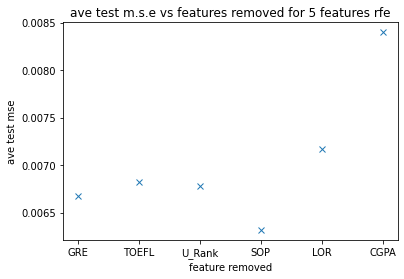

In [22]:
#Plot the min m.s.e of 5 features vs the feature removed.
plt.plot(['GRE','TOEFL','U_Rank','SOP','LOR','CGPA'],mse_5_features_ave,linestyle='None',marker = 'x')
plt.ylabel('ave test mse')
plt.xlabel('feature removed')
plt.title("ave test m.s.e vs features removed for 5 features rfe")
plt.savefig('./figures/2B_brute_force_5_features_mse.png')
plt.show()

In [27]:
#Keep model with lowest MSE (from removing the feature 3 or SOP)
X5_train, X5_test = train_data_5_feature[3],test_data_5_feature[3]
print(X5_train)

[[ 1.42832554  1.60033916  0.81007205  0.63111055  1.75693791]
 [ 2.03141     2.09401705  1.68922001  1.17990233  1.65722655]
 [-1.07016722 -0.86805029 -0.94822387  0.63111055  0.21141182]
 ...
 [-0.20861799 -0.3743724  -0.06907591 -1.0152648  -0.50318626]
 [-1.41478691 -1.19716888 -0.06907591 -0.46647302  0.0950819 ]
 [-0.29477291 -0.86805029 -0.06907591 -1.0152648   0.12831902]]


In [28]:
print(X5_test)

[[-0.72554753 -0.2098131  -0.06907591 -1.0152648  -0.6527533 ]
 [ 0.39446647  0.28386479  0.81007205  0.63111055  0.12831902]
 [-1.15632214 -1.19716888 -0.94822387  0.08231877 -0.9020317 ]
 [-1.84556153 -1.36172818 -0.94822387 -0.46647302 -1.58339266]
 [-0.03630815 -0.86805029 -0.06907591 -0.46647302 -1.99885666]
 [-0.46708276 -1.36172818 -1.82737184 -0.46647302 -0.28714498]
 [ 2.03141     2.09401705  0.81007205  1.72869412  1.49104095]
 [ 1.2560157   1.60033916  0.81007205  1.72869412  1.35809247]
 [ 1.2560157   1.27122056  1.68922001  0.08231877  1.39132959]
 [-0.9840123   0.11930549  1.68922001 -0.46647302 -0.20405218]
 [ 0.91139601 -0.5389317   1.68922001  0.08231877  0.39421598]
 [ 0.48062139  0.44842408  0.81007205  1.72869412  0.87615422]
 [ 0.39446647  0.28386479 -0.06907591 -0.46647302 -0.10434082]
 [-0.12246307 -1.19716888 -1.82737184 -1.0152648  -1.08483586]
 [ 1.68679031  1.92945775  1.68922001  0.08231877  1.98959775]
 [ 1.08370585  0.94210197  1.68922001  1.17990233  1.40